# INTRODUÇÃO

Esse notebook busca identificar o perfil do cliente que dá churn além de prever se o cliente irá dar churn ou não.

colunas:
-customer_id, unused variable.
-credit_score, used as input.
country, used as input.
gender, used as input.
age, used as input.
tenure, used as input.
balance, used as input.
products_number, used as input.
credit_card, used as input.
active_member, used as input.
estimated_salary, used as input.
churn, used as the target. 1 if the client has left the bank during some period or 0 if he/she has not.




In [110]:
#imports basicos
import numpy as np
import pandas as pd
import plotly.express as px

# analise exploratoria
import matplotlib.pyplot as plt
import seaborn as sns

#configurações
plt.style.use('ggplot')

#estatistica
from scipy.stats import skew
import scipy.stats as stats
import statsmodels.api as sm

#preprocessamento
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer

#regressão logística
from sklearn.linear_model import LogisticRegression

#avaliação do modelo
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#métodos de avaliação avançados
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# IMPORTANDO ARQUIVO

In [111]:
churn = pd.read_csv(r'Bank Customer Churn Prediction.csv')
churn.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [112]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [113]:
churn.nunique().sort_values()

gender                  2
credit_card             2
active_member           2
churn                   2
country                 3
products_number         4
tenure                 11
age                    70
credit_score          460
balance              6382
estimated_salary     9999
customer_id         10000
dtype: int64

In [114]:
churn.country.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [115]:
idade_min = churn.age.min()
idade_max = churn.age.max()

print(f"Nosso dataset contém clientes cuja idade vai de {idade_min} até {idade_max} anos")

Nosso dataset contém clientes cuja idade vai de 18 até 92 anos


In [116]:
saldo_min = churn.balance.min()
saldo_max = churn.balance.max()

print(f"Nosso dataset contém clientes cuja idade vai de {saldo_min} até {saldo_max} reais")

Nosso dataset contém clientes cuja idade vai de 0.0 até 250898.09 reais


In [117]:
churn.query("balance == 0")

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.0,1,1,1,101348.88,1
3,15701354,699,France,Female,39,1,0.0,2,0,0,93826.63,0
6,15592531,822,France,Male,50,7,0.0,2,1,1,10062.80,0
11,15737173,497,Spain,Male,24,3,0.0,2,1,0,76390.01,0
12,15632264,476,France,Female,34,10,0.0,2,1,0,26260.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,15605622,841,Spain,Male,28,4,0.0,2,1,1,179436.60,0
9992,15657105,726,Spain,Male,36,2,0.0,1,1,0,195192.40,0
9994,15719294,800,France,Female,29,2,0.0,2,0,0,167773.55,0
9995,15606229,771,France,Male,39,5,0.0,2,1,0,96270.64,0


vamos agora verificar os clientes com maior saldo e maior salario

In [118]:
churn.query(f"balance in {churn.balance.nlargest(3).to_list()} or estimated_salary in {churn.estimated_salary.nlargest(3).to_list()}")

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
2092,15757408,655,Spain,Male,38,3,250898.09,3,0,1,81054.00,1
3280,15715622,583,France,Female,57,3,238387.56,1,0,1,147964.99,1
3580,15634359,639,Germany,Female,41,5,98635.77,1,1,0,199970.74,0
4417,15697270,608,Spain,Male,27,4,153325.10,1,1,1,199953.33,0
6646,15662021,685,Spain,Female,42,2,0.00,2,0,0,199992.48,0
8733,15714241,749,Spain,Male,42,9,222267.63,1,0,0,101108.85,1


# EXPLORATORY DATA ANALYSIS

In [119]:
gender = churn.gender.value_counts(normalize=True)
gender

Male      0.5457
Female    0.4543
Name: gender, dtype: float64

In [120]:
fig = px.bar(gender, title="Distribuição de sexo", text_auto=True)
fig.update_layout(height=400, width=600)
fig.show()

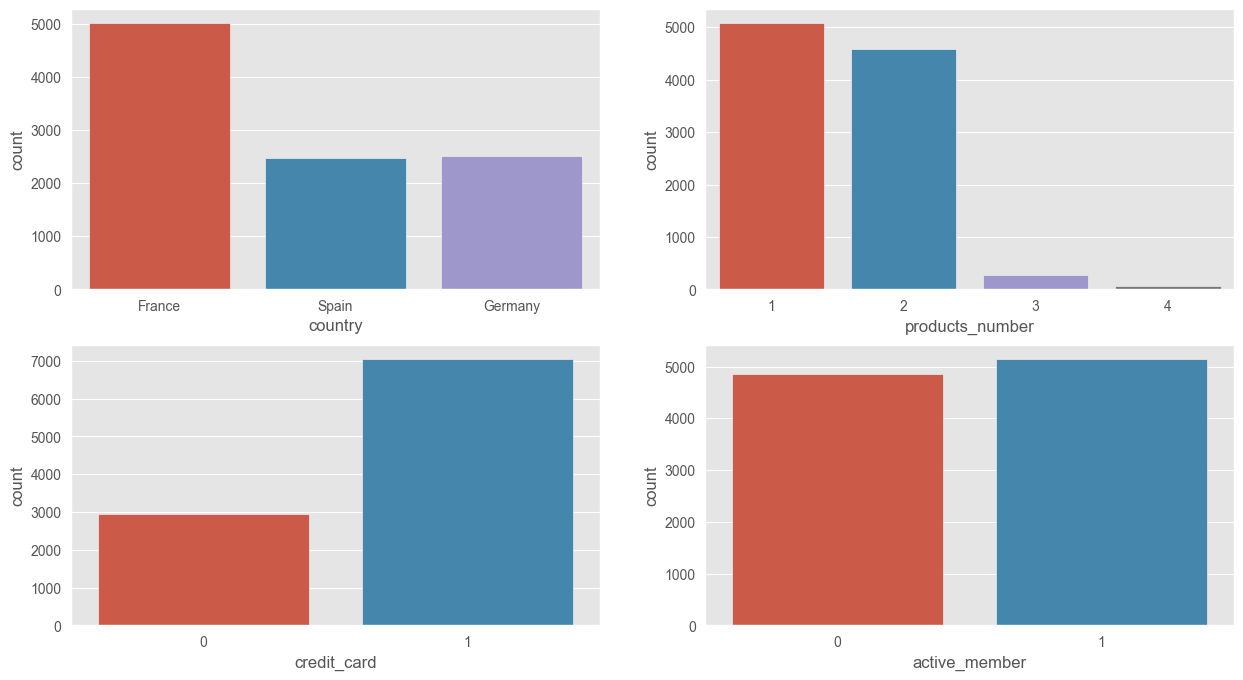

In [121]:
fig, axes = plt.subplots(2, 2, figsize=(15,8))
_ = sns.countplot(data=churn, x='country', ax=axes[0][0])
_ = sns.countplot(data=churn, x='products_number', ax=axes[0][1])
_ = sns.countplot(data=churn, x='credit_card', ax=axes[1][0])
_ = sns.countplot(data=churn, x='active_member', ax=axes[1][1])


vamos agora verificar a variável balance

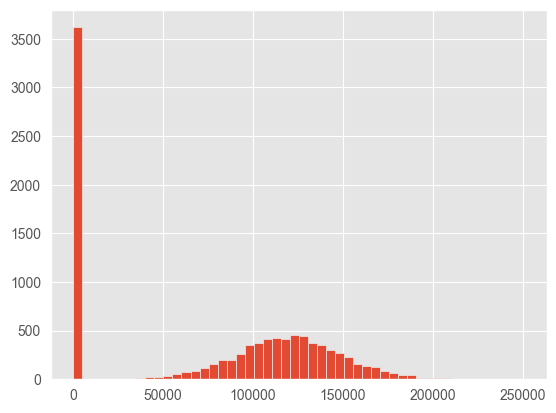

In [122]:
_ = plt.hist(churn.balance, bins = 50)

qual percentual de clientes com zero de saldo?

In [123]:
clientes_zerados = len(churn.query('balance == 0'))
total_clientes = len(churn)

print (f"Temos {clientes_zerados/total_clientes} de nosso clientes sem saldo")

Temos 0.3617 de nosso clientes sem saldo


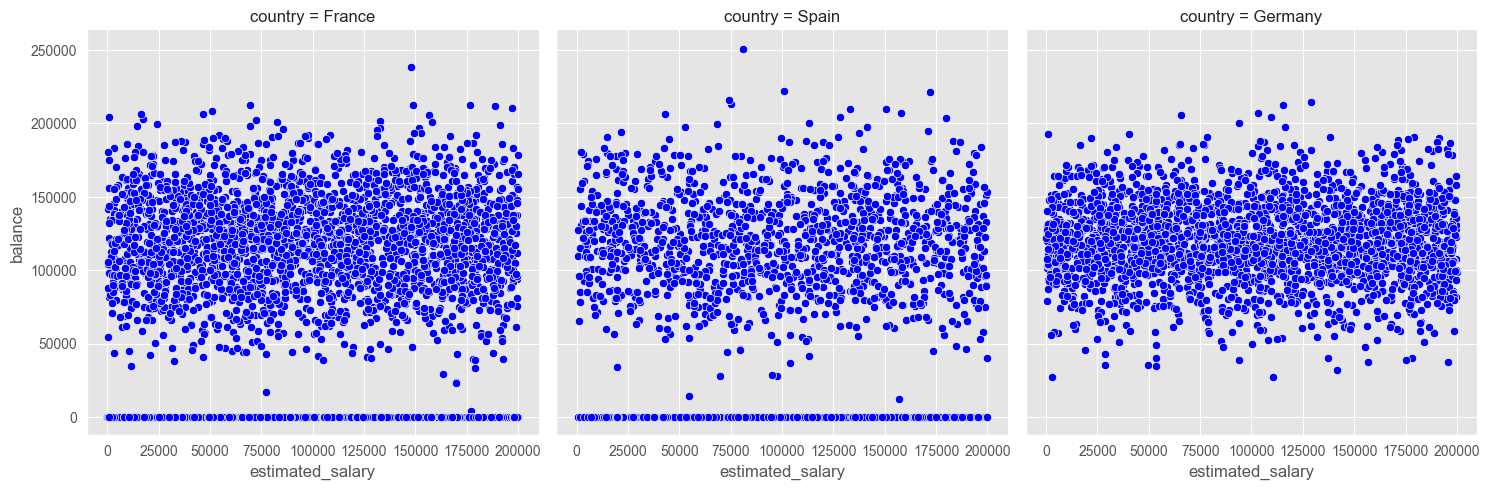

In [124]:
_ = sns.relplot(x = 'estimated_salary', y= 'balance', data=churn, col='country', color='b')

não há relação entre saldo e salário

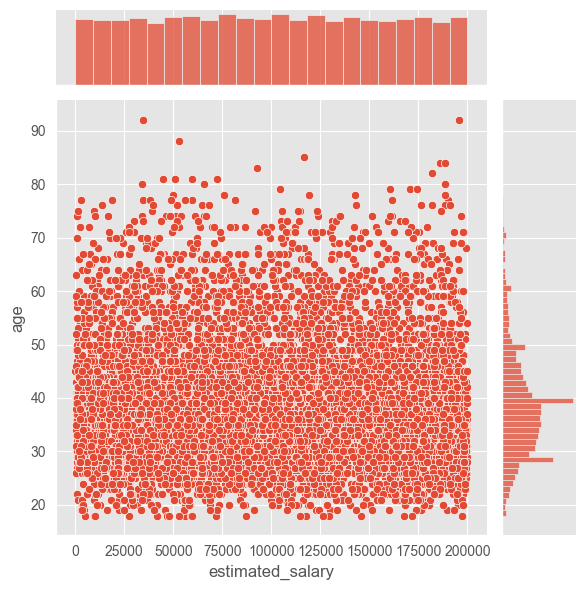

In [125]:
_ = sns.jointplot(x='estimated_salary', y='age', data=churn)

# ANÁLISE DE CHURN

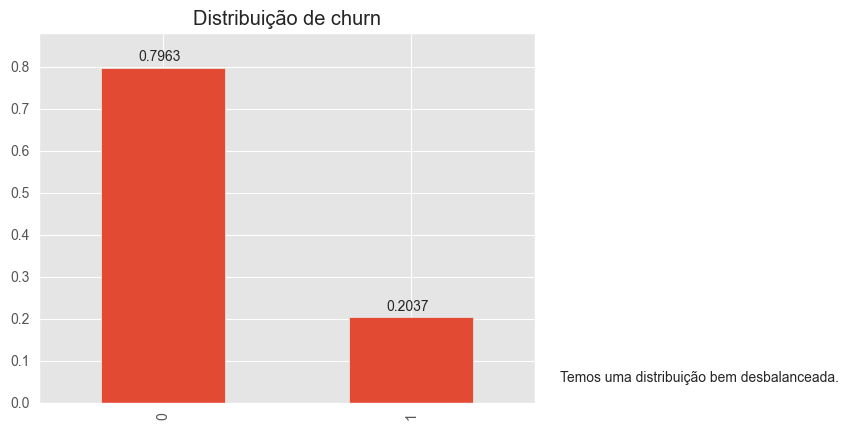

In [126]:
_ = churn.churn.value_counts(1).plot.bar()
_ = plt.title("Distribuição de churn")
_ = plt.text(-0.1,0.815, churn.churn.value_counts(1)[0])
_ = plt.text(0.9,0.22, churn.churn.value_counts(1)[1])
_ = plt.ylim(0, 0.88)
_ = plt.text(1.6, 0.05, "Temos uma distribuição bem desbalanceada.")

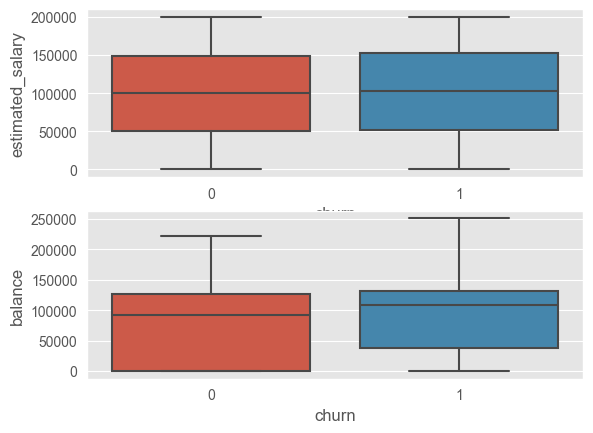

In [127]:
fig, axes = plt.subplots (2, 1)

_ = sns.boxplot(data=churn, x= "churn", y="estimated_salary", ax = axes[0])
_ = sns.boxplot(data=churn, x= "churn", y="balance", ax = axes[1])

Aparentemente o salário não importa muito para o churn, porém parece que o saldo bancário possui uma relação com o churn. As pessoas que possuem saldo maior tem maior propensão de dar churn.

In [128]:
churn.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
credit_score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
products_number,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
credit_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
active_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
churn,10000.0,2.037000e-01,0.402769,0.00,0.00,0.000000e+00,0.000000e+00,1.00


In [129]:
churn.groupby('churn')['balance'].median()

churn
0     92072.68
1    109349.29
Name: balance, dtype: float64

In [130]:
churn.groupby('churn').agg({'balance':['mean', 'median', 'max']})

balance                      
               mean     median        max
churn                                    
0      72745.296779   92072.68  221532.80
1      91108.539337  109349.29  250898.09

In [131]:
agg_func = {
    'estimated_salary':['min', 'max', 'median','mean','std','skew'],
    'balance':['min', 'max', 'median','mean','std','skew'],
    'age':['min', 'max', 'median','mean','std','skew']
}

churn.groupby('churn').agg(agg_func)

estimated_salary                                                     \
                   min        max     median           mean           std   
churn                                                                       
0                90.07  199992.48   99645.04   99738.391772  57405.586966   
1                11.58  199808.10  102460.84  101465.677531  57912.418071   

                balance                                                    \
           skew     min        max     median          mean           std   
churn                                                                       
0      0.010996     0.0  221532.80   92072.68  72745.296779  62848.040701   
1     -0.033104     0.0  250898.09  109349.29  91108.539337  58360.794816   

                age                                             
           skew min max median       mean        std      skew  
churn                                                           
0     -0.046887  18  92   36.0  37.408389  10.125363  1.377699  
1     -0.512732  18  84   45.0  44.837997   9.761562  0.077978

Será que a diferença na média de idades é significativa? Vamos fazer um teste t para responder a essa pergunta:

In [132]:
age_churn1 = churn[churn['churn'] == 1]['age']
age_churn0 = churn[churn['churn'] == 0]['age']
#teste estatistico:
t_stat, p_value = stats.ttest_ind(age_churn1, age_churn0)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 29.76681499437077
p-value: 1.2399313093427738e-186


como o valor p é bem abaixo do valor de significancia (0.05) concluimos que há sim uma diferença significativa no valor das idades

fazer teste de hipoteses para ver se a diferença na media de idades é significativa ou não

In [133]:
churn.groupby('credit_card').agg(agg_func)

estimated_salary                                       \
                         min        max     median           mean   
credit_card                                                         
0                      90.07  199992.48  101617.43  100974.397711   
1                      11.58  199970.74   99398.36   99721.161949   

                                    balance                       \
                      std      skew     min        max    median   
credit_card                                                        
0            57761.338594 -0.037281     0.0  250898.09  97990.49   
1            57405.532277  0.018579     0.0  221532.80  96877.21   

                                                  age                        \
                     mean           std      skew min max median       mean   
credit_card                                                                   
0            77920.787552  61951.756426 -0.170403  18  92   38.0  39.112054   
1            75886.913330  62577.134010 -0.128766  18  92   37.0  38.842381   

                                  
                   std      skew  
credit_card                       
0            10.528381  0.963378  
1            10.470548  1.031906

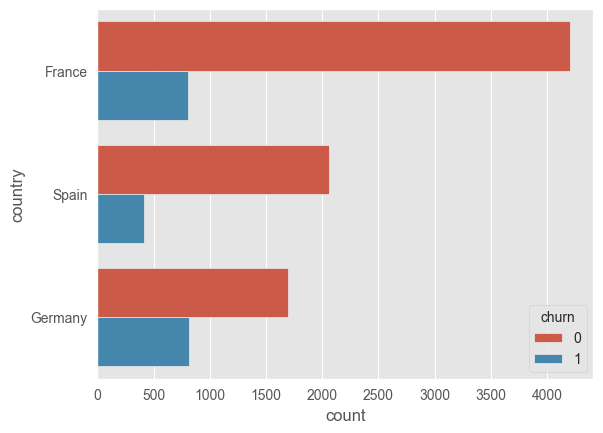

In [134]:
_ = sns.countplot(data=churn, y = 'country', hue='churn')

In [135]:
churn.groupby('country')['churn'].mean().sort_values()

country
France     0.161548
Spain      0.166734
Germany    0.324432
Name: churn, dtype: float64

In [136]:
churn.groupby('credit_card')['churn'].mean().sort_values()

credit_card
1    0.201843
0    0.208149
Name: churn, dtype: float64

In [137]:
churn.groupby('gender')['churn'].mean().sort_values()

gender
Male      0.164559
Female    0.250715
Name: churn, dtype: float64

De acordo com o gráfico podemos ver que o país em que mais ocorre churn é a alemanha. E de acordo com os dados expostos não há diferença significativa de churn entre quem tem ou não cartão de crédito e entre os sexos o feminino possui maior tendência de churn.

# VERIFICAÇÃO DO DATASET

Antes de entrarmos na predição, vamos fazer verificações de erros e coisas que podem prejudicar a performance do modelo

1 - Verificação de nulos

In [138]:
colunas = churn.columns

for col in colunas:
    a = churn[col].isnull().sum()
    print(a)

0
0
0
0
0
0
0
0
0
0
0
0


# MODELO DE PREDIÇÃO

nesse caso será utilizado a regressão logística

primeiramente devemos fazer o split dos dados para evitar data leak:

In [139]:
#vamos dropar a coluna ID pois ela não importa para nosso modelo preditivo
churn = churn.drop(['customer_id'], axis=1)

In [140]:
#criando os dataframes X e y:
X = churn.drop(['churn'], axis=1)
y = churn['churn']

In [141]:
X.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [142]:
#split dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

## FEATURE ENGINEERING

Nesta etapa faremos o feature engineering de forma a evitar data leakage

In [143]:
#transformer do genero
class GenderTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['gender'] = X_transformed['gender'].map({'Male': 1, 'Female': 0})
        
        # Handle missing values
        X_transformed['gender'] = X_transformed['gender'].fillna(-1)  # Replace NaN with a desired value
        
        return X_transformed

In [144]:
unique_values = X_train['gender'].unique()
unique_values

array(['Female', 'Male'], dtype=object)

Finalmente fazemos o column transformer para termos todas essas transformações para nossos datasets de treino e teste:

In [145]:
preprocessor = ColumnTransformer(
    transformers=[
        ('Transformação da coluna gender', GenderTransformer(), ['gender']),
        ('paises one hot', OneHotEncoder(),['country'])
    ], remainder='passthrough'
    )

agora iremos aplicar as transformações tanto nos dados de treino quanto de teste:

In [146]:

X_traint = preprocessor.fit_transform(X_train)

In [147]:
X_testt = preprocessor.fit_transform(X_test)

In [148]:
columns = ['gender','France','Germany','Spain','credit_score','age','tenure','balance','products_number','credit_card','active_member','estimated_salary']

In [149]:
pd.DataFrame(X_traint, columns=columns)

,gender,France,Germany,Spain,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,0.0,1.0,0.0,0.0,589.0,21.0,3.0,0.00,2.0,0.0,1.0,55601.44
1,0.0,1.0,0.0,0.0,617.0,79.0,7.0,0.00,1.0,1.0,1.0,160589.18
2,0.0,0.0,1.0,0.0,798.0,39.0,6.0,119787.76,1.0,1.0,1.0,164248.33
3,1.0,0.0,0.0,1.0,640.0,39.0,3.0,0.00,1.0,1.0,1.0,105997.25
4,1.0,0.0,1.0,0.0,706.0,31.0,1.0,117020.08,2.0,1.0,0.0,54439.53
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,1.0,1.0,0.0,0.0,733.0,33.0,3.0,0.00,1.0,1.0,1.0,7666.73
7496,0.0,1.0,0.0,0.0,487.0,34.0,2.0,96019.50,1.0,0.0,0.0,9085.00
7497,0.0,1.0,0.0,0.0,686.0,34.0,3.0,123971.51,2.0,1.0,0.0,147794.63
7498,1.0,1.0,0.0,0.0,637.0,41.0,2.0,0.00,2.0,0.0,1.0,102515.42


In [150]:
target_value = 54439.53
column_name = 'estimated_salary'
row = X_train.loc[X_train[column_name] == target_value]
row

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
5774,706,Germany,Male,31,1,117020.08,2,1,0,54439.53


## MODELAGEM

E assim finalmente criaremos nosso modelo de regressão logística:

In [151]:
#instanciando o modelo:
logreg = LogisticRegression()

In [152]:
#aplicando o modelo de regressão:
model = logreg.fit(X_traint, y_train)

# AVALIAÇÃO DO MODELO

In [153]:
y_pred = logreg.predict(X_testt)

In [154]:
#acurácia
print('Acurácia da regressão logística nos dados de teste: {:.2f}'.format(accuracy_score(y_test, y_pred)))

Acurácia da regressão logística nos dados de teste: 0.80


agora vamos fazer a matriz de confusão

Text(0.5, 427.9555555555555, 'Predicted label')

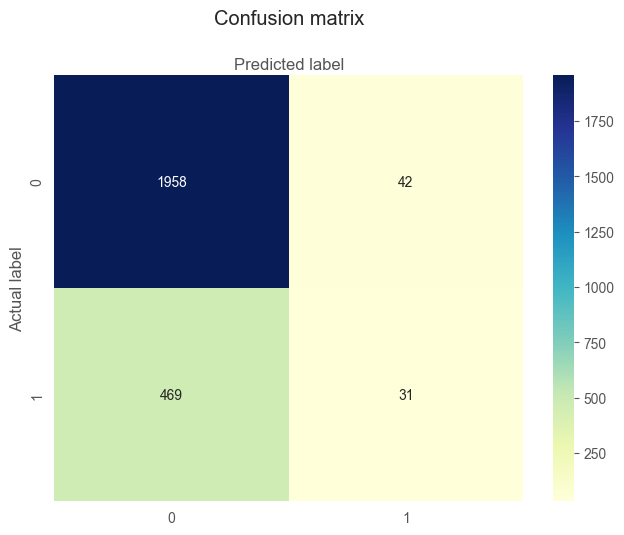

In [155]:
cnf_matrix = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



esse resultado acima está nos informando que temos 1989 predições corretas e 511 predições incorretas na nossa primeira iteração

O resultado acima é alarmante e explica as métricas ruins abaixo pois mesmo tendo poucas predições incorretas, devemos lembrar que o target é desbalanceado portanto a maioria de seus resultados está incorreto.

In [156]:
target_names = ['sem churn', 'churn']
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

   sem churn       0.81      0.98      0.88      2000
       churn       0.42      0.06      0.11       500

    accuracy                           0.80      2500
   macro avg       0.62      0.52      0.50      2500
weighted avg       0.73      0.80      0.73      2500



Observando o precision, reparamos que conseguimos predizer apenas 42% das vezes quando um churn realmente ocorreu. O recall da classe 1 nos mostra que conseguimos pegar apenas 6% dos churn que realmente ocorreram, indicando que há muito o que melhorar no modelo. Apenas de modo didático vamos ver o ROC curve abaixo:

In [157]:
# Assuming `model` is your trained logistic regression model
y_pred_prob = model.predict_proba(X_testt)

# Extract the probabilities for the positive class
y_pred = y_pred_prob[:, 1]

In [158]:
len(y_train)

7500

In [159]:
len(y_test)

2500

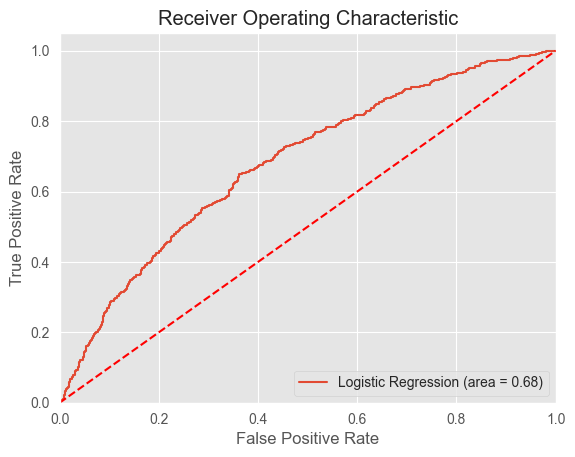

In [160]:
# Assuming `model` is your trained logistic regression model
y_pred_prob = model.predict_proba(X_testt)

# Extract the probabilities for the positive class
y_pred_prob_positive = y_pred_prob[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_positive)

# Compute the ROC AUC score
logit_roc_auc = roc_auc_score(y_test, y_pred_prob_positive)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

O fato de termos como resultado de AUC como 0.68 indica também que o fit não é bom. Vamos abaixo tentar melhorar essa regressão

# TUNANDO A REGRESSÃO

Nesta seção vamos mudar vários parâmetros da regressão logística de forma a maximizar o fit dela. Abaixo vamos colocar cada modificação e os seus resultados:

0 - Modelo original
    accuracy: 0.8
    recall (churn): 0.06
    precision(churn): 0.42
    F1 (churn): 0.11
    AUC: 0.68    


1 - Colocando o valor ótimo de class_weight
    accuracy: 0.68
    recall (churn): 0.66
    precision(churn): 0.34
    F1 (churn): 0.45
    AUC: 0.72


2 - Padronizando via StandardScaler
    accuracy: 0.73
    recall (churn): 0.66
    precision(churn): 0.4
    F1 (churn): 0.50
    AUC: 0.78

Podemos ver que ao colocar o class_weight, houve uma melhora substancial no modelo, visto pelos valores de todas essas métricas. Ao realizar a padronização, houve mais uma melhora nas métricas.
    

Como a classe é desbalanceada, primeiramente vamos mudar seu class_weight, aplicando um grid search para encontrar o valor ótimo. Após isso será feita uma padronização utilizando StandardScaler:

In [161]:
num_features = ['credit_score', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary']

In [162]:
#column transformer final
preprocessor2 = ColumnTransformer(
    transformers=[
        ('Transformação da coluna gender', GenderTransformer(), ['gender']),
        ('paises one hot', OneHotEncoder(),['country']),
        ('padronização', StandardScaler(), num_features)
    ], remainder='passthrough'
    )

In [163]:
X_train_final = preprocessor2.fit_transform(X_train)

In [164]:
X_test_final = preprocessor2.fit_transform(X_test)

In [165]:
columns = ['gender','France','Germany','Spain','credit_score','age','tenure','balance','products_number','credit_card','active_member','estimated_salary']

In [166]:
pd.DataFrame(X_train_final, columns=columns)

,gender,France,Germany,Spain,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,0.0,1.0,0.0,0.0,-0.645417,-1.705560,-0.694237,-1.227468,0.808105,-1.553124,0.962053,-0.766237
1,0.0,1.0,0.0,0.0,-0.354187,3.807734,0.688063,-1.227468,-0.912243,0.643864,0.962053,1.057814
2,0.0,0.0,1.0,0.0,1.528406,0.005463,0.342488,0.698494,-0.912243,0.643864,0.962053,1.121388
3,1.0,0.0,0.0,1.0,-0.114962,0.005463,-0.694237,-1.227468,-0.912243,0.643864,0.962053,0.109337
4,1.0,0.0,1.0,0.0,0.571508,-0.754992,-1.385388,0.653995,0.808105,0.643864,-1.039444,-0.786424
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,1.0,1.0,0.0,0.0,0.852337,-0.564878,-0.694237,-1.227468,-0.912243,0.643864,0.962053,-1.599052
7496,0.0,1.0,0.0,0.0,-1.706326,-0.469821,-1.039813,0.316345,-0.912243,-1.553124,-1.039444,-1.574411
7497,0.0,1.0,0.0,0.0,0.363487,-0.469821,-0.694237,0.765761,0.808105,0.643864,-1.039444,0.835522
7498,1.0,1.0,0.0,0.0,-0.146166,0.195576,-1.039813,-1.227468,0.808105,-1.553124,0.962053,0.048844


# CLASS WEIGHT

Como a classe é desbalanceada, primeiramente vamos mudar seu class_weight, aplicando um grid search para encontrar o valor ótimo:

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Optimal class weight: {0: 0.22386934673366835, 1: 0.7761306532663317}


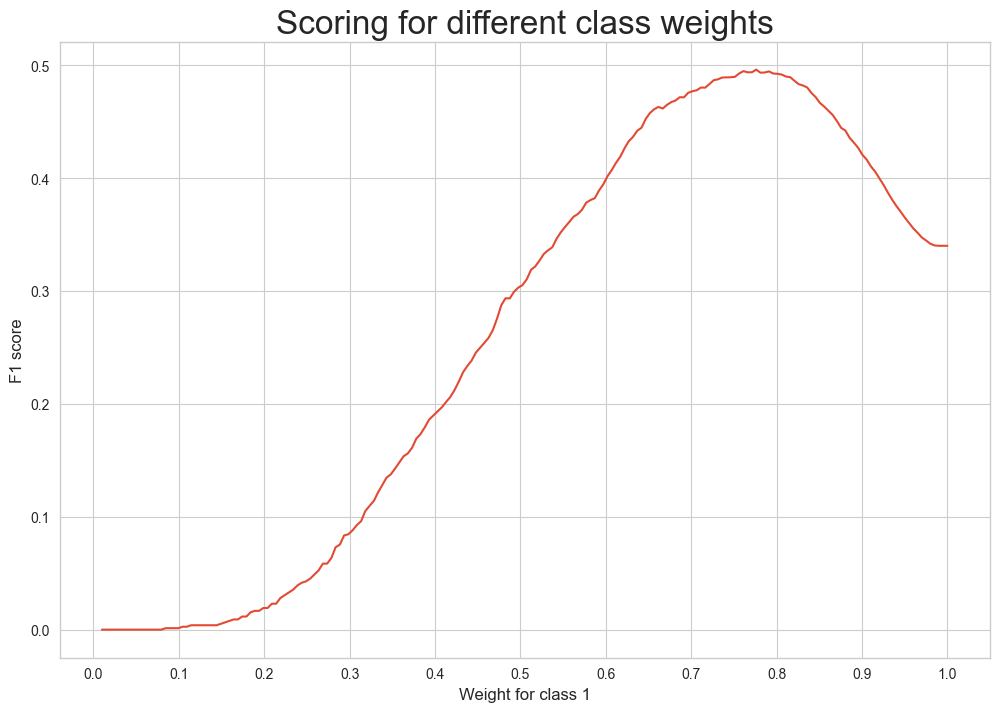

In [167]:
#Fazendoo  range de valores desejados de class_weight
weights = np.linspace(0.0,0.99,200)

#Criando um grid de dicionario para o gridsearch
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitando o grid search com os dados de treino e 5 folds:
gridsearch = GridSearchCV(estimator= logreg, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_final, y_train)

#Plotando o score para diferentes valores de weight:
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(x=weigh_data['weight'], y=weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

# Pegando os melhores parâmetros de GridSearchCV
best_params = gridsearch.best_params_

# Extraindo o class_weight dos melhores parâmetros:
best_class_weight = best_params['class_weight']

# Printando o valor ótimo de class_weight:
print("Optimal class weight:", best_class_weight)

# CRIANDO O MODELO

In [168]:
#criando o modelo de regressão final
lr = LogisticRegression(class_weight=best_class_weight)

In [169]:
#aplicando o modelo de regressão:
model_final = lr.fit(X_train_final, y_train)

AVALIANDO O MODELO

In [170]:
y_pred_final = lr.predict(X_test_final)

In [171]:
#acurácia
print('Acurácia da regressão logística nos dados de teste: {:.2f}'.format(accuracy_score(y_test, y_pred_final)))

Acurácia da regressão logística nos dados de teste: 0.73


Text(0.5, 427.9555555555555, 'Predicted label')

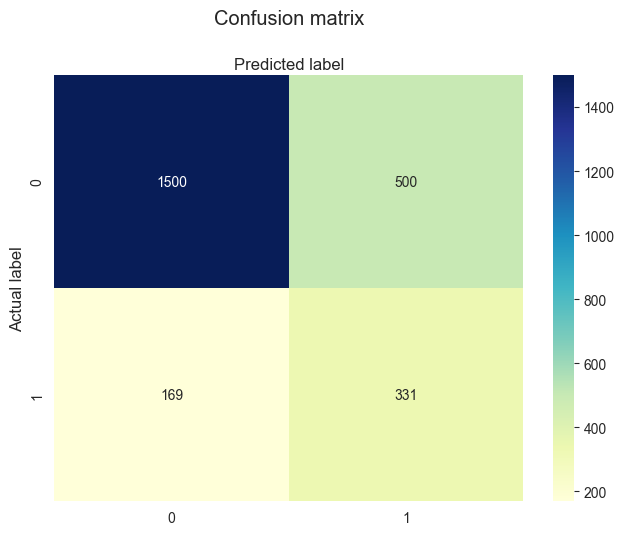

In [172]:
cnf_matrix = confusion_matrix(y_test, y_pred_final)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



In [174]:
target_names = ['sem churn', 'churn']
print(classification_report(y_test, y_pred_final, target_names=target_names))

              precision    recall  f1-score   support

   sem churn       0.90      0.75      0.82      2000
       churn       0.40      0.66      0.50       500

    accuracy                           0.73      2500
   macro avg       0.65      0.71      0.66      2500
weighted avg       0.80      0.73      0.75      2500



In [175]:
# Assuming `model` is your trained logistic regression model
y_pred_prob = model_final.predict_proba(X_test_final)

# Extract the probabilities for the positive class
y_pred = y_pred_prob[:, 1]

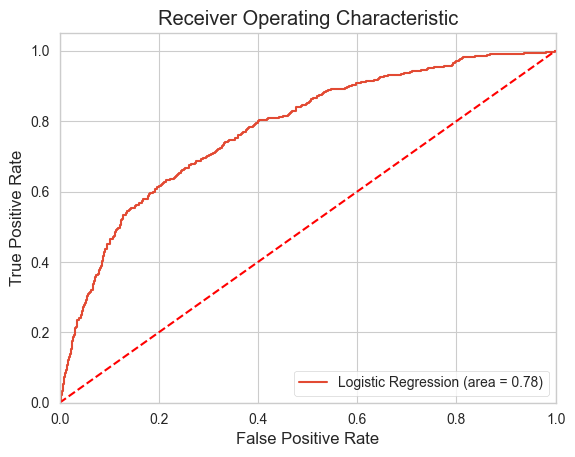

In [176]:
# Assuming `model` is your trained logistic regression model
y_pred_prob = model_final.predict_proba(X_test_final)

# Extract the probabilities for the positive class
y_pred_prob_positive = y_pred_prob[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_positive)

# Compute the ROC AUC score
logit_roc_auc = roc_auc_score(y_test, y_pred_prob_positive)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# CUSTOS DE OPORTUNIDADE

In [207]:
# Setando o valor de corte da regressão
threshold = 0.35

# Classificando as amostras de acordo com o valor de corte
y_pred = (y_pred_prob >= threshold).astype(int)

In [208]:
# convertendo y_pred e y_test para arrays booleanos
y_pred_bool = np.argmax(y_pred, axis=1)
y_test_bool = y_test.astype(bool)

# Calculando o numero de verdadeiros positivos, verdadeiro negativos, falso positivos e falso negativos:
true_positives = ((y_pred_bool == 1) & (y_test_bool == True)).sum()
true_negatives = ((y_pred_bool == 0) & (y_test_bool == False)).sum()
false_positives = ((y_pred_bool == 1) & (y_test_bool == False)).sum()
false_negatives = ((y_pred_bool == 0) & (y_test_bool == True)).sum()

print("True Positives:", true_positives)
print("True Negatives:", true_negatives)
print("False Positives:", false_positives)
print("False Negatives:", false_negatives)

True Positives: 225
True Negatives: 1805
False Positives: 195
False Negatives: 275


Supondo que para os clientes que irão dar churn faremos uma ação específica de vantagens e marketing que irá custar 40 reais, e o LTV deste cliente é de 80 reais, vamos verificar se esse modelo está valendo a pena:

In [209]:
acao_vantagens = 40
LTV = 55

custo_churn = (int(true_negatives) + int(false_negatives))* acao_vantagens
custo_extra = int(false_negatives)* acao_vantagens
LTV_churn = int(true_negatives)* LTV
LTV_perdido = int(false_positives) * LTV

balanço_total = LTV_churn - (custo_churn + LTV_perdido)


print("Custo total da campanha para churn: R$", custo_churn)
print("Custo extra dando campanha a quem não precisava: R$", custo_extra)
print("Retorno financeiro dos clientes que evitaram churn: R$", LTV_churn)
print("LTV perdido de clientes que o modelo não pegou: R$", LTV_perdido)

print("Balanço do modelo: R$", balanço_total)


Custo total da campanha para churn: R$ 83200
Custo extra dando campanha a quem não precisava: R$ 11000
Retorno financeiro dos clientes que evitaram churn: R$ 99275
LTV perdido de clientes que o modelo não pegou: R$ 10725
Balanço do modelo: R$ 5350


Neste modelo acima, se deixarmos o threshold em 50%, o modelo dará um prejuízo de 11760 reais, por isso modificaremos o threshold para 0.35 para dar um lucro de 5350 reais